<a href="https://colab.research.google.com/github/tkeldenich/Keras_GradCam/blob/main/Fast_Neural_Style_Transfer_Execution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](https://i.imgur.com/kJtHuUh.jpg)

/demo
/demo/examples/fast_neural_style
/demo/examples/fast_neural_style/neural_style


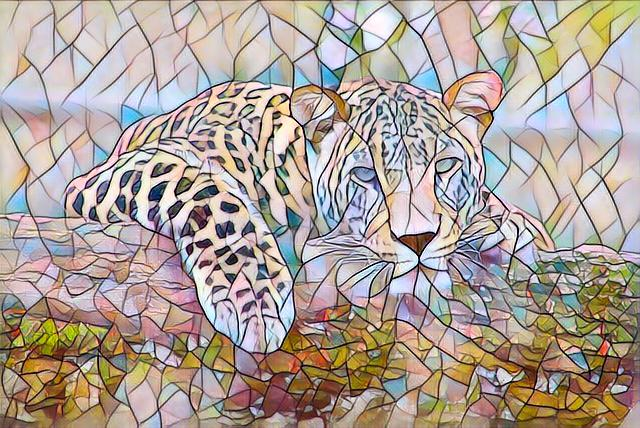

True

In [15]:
import os
assert os.environ['COLAB_TPU_ADDR'], 'Make sure to select TPU from Edit > Notebook settings > Hardware accelerator'
!pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.7-cp36-cp36m-linux_x86_64.whl &> /dev/null

#Installs PyTorch & Loads the Networks

from google.colab.patches import cv2_imshow
import cv2
import sys

# Configures repo in local colab fs
REPO_DIR = '/demo'
%mkdir -p "$REPO_DIR"
%cd "$REPO_DIR" 
%rm -rf examples
!git clone https://github.com/pytorch/examples.git &> /dev/null
%cd "$REPO_DIR/examples/fast_neural_style"

# Download pretrained weights for styles
!python download_saved_models.py &> /dev/null
%cd "$REPO_DIR/examples/fast_neural_style/neural_style"


## Creates pre-trained style networks
import argparse
import os
import sys
import time
import re

import numpy as np
import torch
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
import torch_xla
import torch_xla.core.xla_model as xm
import torch_xla.debug.metrics as met
import torch_xla.distributed.parallel_loader as pl
import torch_xla.distributed.xla_multiprocessing as xmp
import torch_xla.utils.utils as xu
import utils
from transformer_net import TransformerNet
from vgg import Vgg16

# Acquires the XLA device (a TPU core)
device = xm.xla_device()

# Loads pre-trained weights
rain_princess_path = '../saved_models/rain_princess.pth'
candy_path = '../saved_models/candy.pth'
mosaic_path = '../saved_models/mosaic.pth'
udnie_path = '../saved_models/udnie.pth'

# Loads the pre-trained weights into the fast neural style transfer
# network architecture and puts the network on the Cloud TPU core.
def load_style(path):
  with torch.no_grad():
    model = TransformerNet()
    state_dict = torch.load(path)
    # filters deprecated running_* keys from the checkpoint
    for k in list(state_dict.keys()):
        if re.search(r'in\d+\.running_(mean|var)$', k):
            del state_dict[k]
    model.load_state_dict(state_dict)
    return model.to(device)

# Creates each fast neural style transfer network
rain_princess = load_style(rain_princess_path)
candy = load_style(candy_path)
mosaic = load_style(mosaic_path)
udnie = load_style(udnie_path)

#Try it out!
#@markdown ### **Transfert de style sur une image** par *Deep Learning* plus d'informations [ici](https://https://inside-machinelearning.com/) !
#content_image_url = 'https://cdn.pixabay.com/photo/2019/06/11/15/42/corgi-face-4267312__480.jpg' #@param {type:"string"}
#@markdown Les étapes:
#@markdown - **Importez** votre image
#@markdown - Entrez le **nom de l'image** ici:
Nom_du_fichier_image = "jaguar.jpg" #@param {type:"string"}
#@markdown - Choisissez le **style** à transferez
style = "mosaic" #@param ["mosaic", "candy", "udnie", "rain_princess"]
#@markdown Puis **exécutez le code** en appuyant sur les touches "Shift + Entrer" ! :)
#content_image = 'content.jpg'
content_image = "/content/"+Nom_du_fichier_image
!wget -O "$content_image"  &> /dev/null #"$content_image_url" &> /dev/null
RESULT_IMAGE = '/tmp/result.jpg'
!rm -f "$RESULT_IMAGE" &> /dev/null
img = cv2.imread(content_image, cv2.IMREAD_UNCHANGED)

content_image = utils.load_image(content_image, scale=None)
content_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.mul(255))
    ])
content_image = content_transform(content_image)
content_image = content_image.unsqueeze(0).to(device)

with torch.no_grad():
  if style == 'rain_princess':
    output = rain_princess(content_image)
  elif style == 'candy':
    output = candy(content_image)
  elif style == 'mosaic':
    output = mosaic(content_image)
  else:
    output = udnie(content_image)

utils.save_image(RESULT_IMAGE, output[0].cpu())
img = cv2.imread(RESULT_IMAGE, cv2.IMREAD_UNCHANGED)
cv2_imshow(img)
cv2.imwrite('/content/resultat.jpg',img)
#cv2_imshow(cv2.resize(img, dsize=(int(img.shape[1]/2), int(img.shape[0]/2)), interpolation=cv2.INTER_CUBIC))